# Library

In [1]:
import os
import glob
import numpy as np
# from ccdproc import ImageFileCollection
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
from scipy.optimize import curve_fit

In [2]:
##	Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

- Functions

In [3]:
def calc_k_prime(table, filte,):
	mag_obs_arr = []
	magerr_obs_arr = []
	mag_ref_arr = []
	airmass_arr = []

	_table = table[table['filter']==filte]
	for nn in range(len(_table)):
		incat = _table['cat'][nn]
		# filte = _table['filter'][nn]
		airmass = _table['airmass'][nn]
		intbl = Table.read(incat, format='ascii')
		c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit="deg")
		##	Matching
		indx_in, sep_in, _ = c.match_to_catalog_sky(c_cat)
		indx_ref, sep_ref, _ = c.match_to_catalog_sky(c_ref)

		mintbl = Table(intbl[indx_in])
		mreftbl = Table(reftbl[indx_ref])

		mag_obs = mintbl['MAG_AUTO'].item()
		magerr_obs = mintbl['MAGERR_AUTO'].item()
		mag_ref = mreftbl[f'{filte}_mag'].item()

		mag_obs_arr.append(mag_obs)
		magerr_obs_arr.append(magerr_obs)
		mag_ref_arr.append(mag_ref)
		airmass_arr.append(airmass)

	mag_obs_arr = np.array(mag_obs_arr)
	magerr_obs_arr = np.array(magerr_obs_arr)
	mag_ref_arr = np.array(mag_ref_arr)
	airmass_arr = np.array(airmass_arr)


	delta_mag = mag_obs_arr - mag_ref_arr

	# 가중치는 오차의 역수로 설정 (큰 오차를 가진 데이터 포인트의 가중치를 줄임)
	weights = 1 / magerr_obs_arr

	# 가중 선형 회귀 수행
	# print(airmass_arr,)
	# print(delta_mag,)
	popt, pcov = curve_fit(linear_model, airmass_arr, delta_mag, sigma=magerr_obs_arr)

	# 회귀 결과
	slope_weighted = popt[0]
	intercept_weighted = popt[1]

	slope_error = np.sqrt(pcov[0,0])
	intercept_error = np.sqrt(pcov[1,1])

	outdict = {
		'mag_obs_arr': mag_obs_arr,
		'magerr_obs_arr': magerr_obs_arr,
		'mag_ref_arr': mag_ref_arr,
		'airmass_arr': airmass_arr,
		'k_p': slope_weighted,
		'k_p_err': slope_error,
		'Z': intercept_weighted, 
		'Z_err': intercept_error,
	}
	return outdict


In [4]:
def get_color(filte0, filte1):
	indx_ref, sep_ref, _ = c.match_to_catalog_sky(c_ref)
	mreftbl = Table(reftbl[indx_ref])
	mag_ref0 = mreftbl[f'{filte0}_mag'].item()
	mag_ref1 = mreftbl[f'{filte1}_mag'].item()

	color = mag_ref0 - mag_ref1

	return color


In [5]:
def linear_model(x, a, b):
	return a * x + b

- Define Target

In [6]:
obj = "LTT7987"
radec = '20 10 56.849 -30 13 06.63'
date = '20231015'

In [7]:
path_data = f"../data/7DT/{obj}"
path_save = f"../output/standardization/{obj}"

if not os.path.exists(path_save):
	os.makedirs(path_save)

In [8]:
reftbl = Table.read(f"{path_data}/gaiaxp_dr3_synphot_{obj}.csv")

In [9]:
c = SkyCoord(radec, unit=(u.hourangle, u.deg))
c_ref = SkyCoord(reftbl['ra'], reftbl['dec'], unit="deg")

- Header Table

In [10]:
table = Table.read(f'{path_data}/summary.csv')
for nn, _cat in enumerate(table['cat']):
	newcat = f"{path_data}/{os.path.basename(_cat)}"
	if os.path.exists(newcat):
		table['cat'][nn] = newcat
	else:
		print(f"No data!")
table[:3]

file,simple,bitpix,naxis,naxis1,naxis2,extend,equinox,mjd-obs,radesys,ctype1,cunit1,crval1,crpix1,cd1_1,cd1_2,ctype2,cunit2,crval2,crpix2,cd2_1,cd2_2,exptime,gain,saturate,softname,softvers,softdate,softauth,softinst,author,origin,date,combinet,imagetyp,xbinning,ybinning,egain,xpixsz,ypixsz,instrume,set-temp,ccd-temp,telescop,focallen,focratio,ra,dec,pierside,siteelev,sitelat,sitelong,fwheel,filter,object,objctra,objctdec,objctrot,focname,focpos,focuspos,focussz,roworder,swcreate,resampt1,centert1,pscalet1,resampt2,centert2,pscalet2,date-obs,date-loc,exposure,centalt,centaz,airmass,mjd,jd,photime,seeing,peeing,ellip,elong,skysig,skyval,refcat,maglow,magup,stdnumb,auto,aper,aper_1,aper_2,aper_3,aper_4,aper_5,zp_auto,ezp_auto,ul3_auto,ul5_auto,zp_0,ezp_0,ul3_0,ul5_0,zp_1,ezp_1,ul3_1,ul5_1,zp_2,ezp_2,ul3_2,ul5_2,zp_3,ezp_3,ul3_3,ul5_3,zp_4,ezp_4,ul3_4,ul5_4,zp_5,ezp_5,ul3_5,ul5_5,comment,cat
str94,str4,int64,int64,int64,int64,str4,float64,float64,str4,str8,str3,float64,float64,float64,float64,str8,str3,float64,float64,float64,float64,int64,float64,float64,str5,str6,str10,str23,str22,str17,str16,str19,str6,str5,int64,int64,float64,float64,float64,str19,float64,float64,str5,float64,float64,float64,float64,str4,float64,float64,float64,str19,str4,str7,str8,str9,float64,str20,int64,int64,float64,str8,str19,str8,str6,str6,str8,str6,str6,str23,str26,int64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,float64,float64,str6,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str63,str98
/large_data/processed/LTT7987/7DT01/g/calib_7DT01_LTT7987_20231015_000552_g_100.com.fits,True,-32,2,10200,6800,True,2000.0,60232.75277778,ICRS,RA---TAN,deg,302.7375,5100.5,-0.0001402777777778,0.0,DEC--TAN,deg,-30.21833333333,3400.5,0.0,0.0001402777777778,100,2750.0,6460.189371278,SWarp,2.41.5,2023-10-20,2010-2012 IAP/CNRS/UPMC,IAP http://www.iap.fr,Gregory S.H. Paek,proton.snu.ac.kr,2023-12-25T21:02:23,MEDIAN,LIGHT,1,1,0.2561904788017,3.76,3.76,Moravian USB Camera,-10.0,-10.01929473877,7DT01,1537.0,3.0,302.7375086311,-30.2183417517,East,1600.0,-30.471,-70.765,Moravian USB Filter,g,LTT7987,20 10 57,-30 13 06,0.0,PlaneWave Focuser (v,7473,7473,1.0,TOP-DOWN,N.I.N.A. 2.2.0.9001,LANCZOS3,MANUAL,MANUAL,LANCZOS3,MANUAL,MANUAL,2023-10-15T00:05:52.016,2023-10-14T21:05:52.016000,100,80.63918079500282,269.310950585384,1.01341940703989,60232.00407425926,2460232.504074259,2023-12-26,2.084,4.127,0.031,1.032,0.394,0.083,GaiaXP,12.0,20.0,458,0.0,5.556,8.255,12.382,5.941,9.901,19.802,24.044,0.009,0.0,0.0,23.267,0.035,21.354,20.8,23.661,0.02,21.318,20.764,23.909,0.016,21.126,20.572,23.346,0.031,21.36,20.805,23.79,0.017,21.25,20.695,24.04,0.01,20.747,20.193,",,, Propagated FITS keywords,, Axis-dependent config parameters",../data/7DT/LTT7987/calib_7DT01_LTT7987_20231015_000552_g_100.com.phot.cat
/large_data/processed/LTT7987/7DT01/g/calib_7DT01_LTT7987_20231015_011752_g_100.com.fits,True,-32,2,10200,6800,True,2000.0,60232.80277778,ICRS,RA---TAN,deg,302.7375,5100.5,-0.0001402777777778,0.0,DEC--TAN,deg,-30.21833333333,3400.5,0.0,0.0001402777777778,100,2750.0,6588.318267265,SWarp,2.41.5,2023-10-20,2010-2012 IAP/CNRS/UPMC,IAP http://www.iap.fr,Gregory S.H. Paek,proton.snu.ac.kr,2023-12-25T21:04:18,MEDIAN,LIGHT,1,1,0.2561904788017,3.76,3.76,Moravian USB Camera,-10.0,-9.933601379395,7DT01,1537.0,3.0,302.7374831999,-30.21834130768,East,1600.0,-30.471,-70.765,Moravian USB Filter,g,LTT7987,20 10 57,-30 13 06,0.0,PlaneWave Focuser (v,7537,7537,1.0,TOP-DOWN,N.I.N.A. 2.2.0.9001,LANCZOS3,MANUAL,MANUAL,LANCZOS3,MANUAL,MANUAL,2023-10-15T01:17:52.491,2023-10-14T22:17:52.491000,100,65.1373168657071,263.349033430788,1.10184173339349,60232.05407975694,2460232.554079757,2023-12-26,1.799,3.562,0.035,1.036,0.388,0.089,Ga

# k'

In [11]:
# filterarr = np.unique(table['filter'])
filterarr = ['u', 'g', 'r', 'i', 'z',]

In [12]:
result_list = []

for filte in filterarr:
	try:
		print(filte)
		result_list.append(calc_k_prime(table, filte=filte))
	except Exception as e:
		print(e)

u
g
r
i
z


In [13]:
# Astropy Table로 변환
kp_table = Table(rows=result_list)
kp_table['filter'] = filterarr
kp_table['filter', 'k_p', 'k_p_err']

filter,k_p,k_p_err
str1,float64,float64
u,0.03908234311905235,0.027572061898507198
g,0.047716412230814235,0.007605317718634082
r,0.04683022516386249,0.009933467132557295
i,0.022207958488881196,0.017237034234029648
z,0.007464391306229275,0.013128045498196407


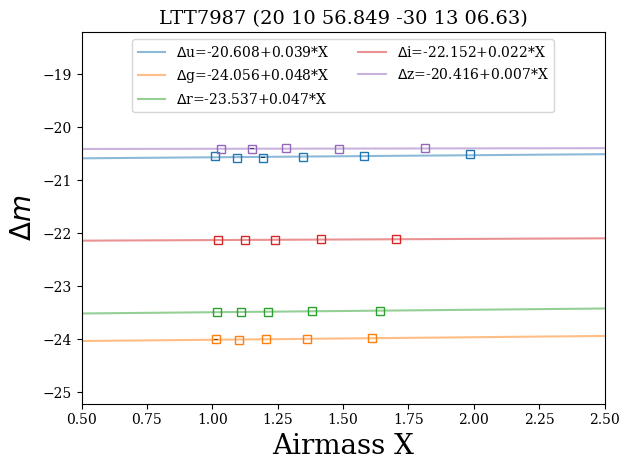

In [14]:
full_airmass_arr = np.arange(0.5, 2.5+0.1, 0.1)

# 플롯으로 결과 시각화
for ff, filte in enumerate(kp_table['filter']):
	_dict = kp_table[kp_table['filter'] == filte]
	airmass_arr = _dict['airmass_arr'].item()
	delta_mag = _dict['mag_obs_arr'].item() - _dict['mag_ref_arr'].item()
	magerr_obs_arr = _dict['magerr_obs_arr'].item()
	Z = _dict['Z'].item()
	k_p = _dict['k_p'].item()

	plt.errorbar(airmass_arr, delta_mag, yerr=magerr_obs_arr, ls='none', color=default_colors[ff], ecolor='k', elinewidth=3, capsize=0)#, label='Data with error bars')
	plt.plot(airmass_arr, delta_mag, marker='s', mfc='none', mec=default_colors[ff], ls='none')
	plt.plot(full_airmass_arr, Z + k_p * full_airmass_arr, color=default_colors[ff], label=r"$\Delta$"+f'{filte}={Z:.3f}+{k_p:.3f}*X', alpha=0.5)

plt.xlabel('Airmass X')
plt.ylabel(r'$\Delta m$')
plt.xlim(0.5, 2.5)
# plt.ylim(np.mean(delta_mag)-0.1, np.mean(delta_mag)+0.1)
plt.title(f'{obj} ({radec})')
plt.legend(loc='upper center', ncol=2)
yl, yu = plt.ylim()
plt.ylim([yl-1.0, yu+2.0])
plt.tight_layout()
plt.show()

# k'' & C

- Bobs− Bstd = Z′B + CB B − V + kB′ X

In [132]:
#	Seperation Cut
sep_cut = 1.0

# ff = 0
# filte = 'u'

ff = 0
filte = filterarr[ff]

_table = table[table['filter']==filte]
nn = 0
# for nn in range(len(_table)):
	# incat = _table['cat'][nn]


matched_table_list = []
airmass_arr = []
for nn in range(len(_table)):
	incat = _table['cat'][nn]
	intbl = Table.read(incat, format='ascii')
	c_cat = SkyCoord(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], unit="deg")
	indx_match, sep_match, _ = c_ref.match_to_catalog_sky(c_cat)
	airmass = _table['airmass'][nn]
	airmass_arr.append(airmass)


	mtbl = hstack([reftbl, intbl[indx_match]])[sep_match.arcsec < sep_cut]
	# delta_mag = mtbl[f"MAG_AUTO_{filte}"] - mtbl[f"{filte}_mag"]
	print(f"{len(mtbl)} sources matched")

	matched_table_list.append(mtbl)

airmass_arr = np.array(airmass_arr)

# 모든 테이블에서 겹치는 좌표의 인덱스를 찾기 위한 초기 설정
coords_list = [SkyCoord(ra=table['ALPHA_J2000'], dec=table['DELTA_J2000'], unit="deg") for table in matched_table_list]
base_coords = coords_list[0]  # 첫 번째 테이블을 기준으로 설정

# 기준 좌표와 나머지 테이블들의 좌표를 비교
common_indices = np.arange(len(base_coords))  # 초기에는 모든 인덱스를 포함
for coords in coords_list[1:]:
    idx, sep, _ = base_coords.match_to_catalog_sky(coords)
    # 일정 거리 이내에서 매칭되는 인덱스만 유지
    matched_idx = idx[sep.arcsec < sep_cut]
    # 교집합을 찾음
    common_indices = np.intersect1d(common_indices, matched_idx)

# 교집합에 해당하는 좌표만을 각 테이블에서 선택
filtered_tables = []
for mtable in matched_table_list:
	filtered_table = mtable[common_indices]
	filtered_tables.append(filtered_table)
	n_matched_source = len(filtered_table)
	print(f"{n_matched_source} sources filtered")

filtered_table0 = filtered_tables[0]

std_star_table = filtered_table0
# std_star_table['g-r'] = [filtered_table0['g_mag'][ii] - filtered_table0['r_mag'][ii] for ii in range(len(filtered_table0))]
std_star_table['g-r'] = filtered_table0['bp_rp']
std_star_table['k_p'] = 0.0
std_star_table['k_p_err'] = 0.0

for nn in range(n_matched_source):
	print(f"[{nn+1}/{n_matched_source} ({(nn+1)/n_matched_source:.1%})]     ", end='\r')

	mag_obs_arr = []
	magerr_obs_arr = []
	mag_ref_arr = []

	_table = table[table['filter']==filte]
	for intbl in filtered_tables:

		mag_obs = intbl['MAG_AUTO'][nn]
		magerr_obs = intbl['MAGERR_AUTO'][nn]
		mag_ref = intbl[f'{filte}_mag'][nn]

		mag_obs_arr.append(mag_obs)
		magerr_obs_arr.append(magerr_obs)
		mag_ref_arr.append(mag_ref)

	mag_obs_arr = np.array(mag_obs_arr)
	magerr_obs_arr = np.array(magerr_obs_arr)
	mag_ref_arr = np.array(mag_ref_arr)

	delta_mag = mag_obs_arr - mag_ref_arr

	# 가중치는 오차의 역수로 설정 (큰 오차를 가진 데이터 포인트의 가중치를 줄임)
	weights = 1 / magerr_obs_arr

	# 가중 선형 회귀 수행
	popt, pcov = curve_fit(linear_model, airmass_arr, delta_mag, sigma=magerr_obs_arr)

	# 회귀 결과
	slope_weighted = popt[0]
	intercept_weighted = popt[1]

	slope_error = np.sqrt(pcov[0,0])
	intercept_error = np.sqrt(pcov[1,1])

	std_star_table['k_p'][nn] = slope_weighted
	std_star_table['k_p_err'][nn] = slope_error


598 sources matched
608 sources matched
599 sources matched
599 sources matched
597 sources matched
579 sources matched
557 sources filtered
557 sources filtered
557 sources filtered
557 sources filtered
557 sources filtered
557 sources filtered


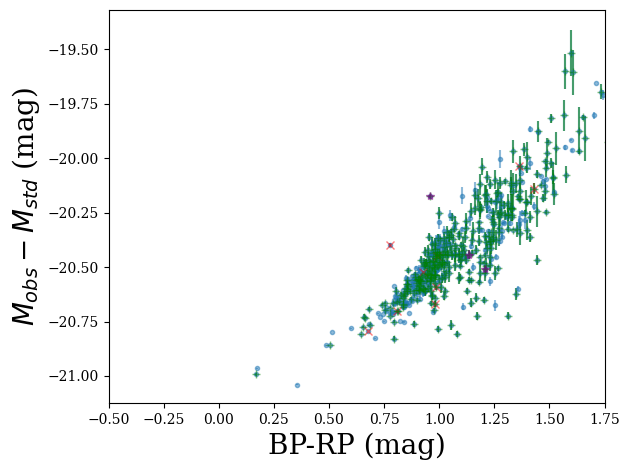

In [133]:
aa = 0

_table = table[table['filter']==filte]

delta_mag = filtered_table0['MAG_AUTO'] - filtered_table0[f'{filte}_mag']
magerr_obs_arr = filtered_table0['MAGERR_AUTO']
plt.close()
plt.errorbar(std_star_table['g-r'], delta_mag, yerr=magerr_obs_arr, alpha=0.5, ls='none', marker='.')
plt.errorbar(std_star_table['g-r'][std_star_table['FLAGS']!=0], delta_mag[std_star_table['FLAGS']!=0], yerr=magerr_obs_arr[std_star_table['FLAGS']!=0], alpha=0.5, ls='none', color='r', marker='x')
plt.errorbar(std_star_table['g-r'][std_star_table['CLASS_STAR']<0.9], delta_mag[std_star_table['CLASS_STAR']<0.9], yerr=magerr_obs_arr[std_star_table['CLASS_STAR']<0.9], alpha=0.5, ls='none', color='g', marker='+')
plt.errorbar(std_star_table['g-r'][std_star_table['C_term']>2], delta_mag[std_star_table['C_term']>2], yerr=magerr_obs_arr[std_star_table['C_term']>2], alpha=0.5, ls='none', color='purple', marker='*')
# plt.xlabel('(g-r) (mag)')
plt.xlabel('BP-RP (mag)')
plt.ylabel(r'$M_{obs}-M_{std}$ (mag)')
plt.xlim(-0.5, +1.75)
plt.tight_layout()
plt.show()
# 가중치는 오차의 역수로 설정 (큰 오차를 가진 데이터 포인트의 가중치를 줄임)
# weights = 1 / magerr_obs_arr

# filtered_table0['FLAGS']
#
# plt.plot(std_star_table['g-r'], std_star_table[''])

indx_filter = np.where(
	(std_star_table['FLAGS']==0) &
	(std_star_table['CLASS_STAR']>0.95) &
	(std_star_table['C_term']<2) &
	(std_star_table['g_mag']>10) &
	(~np.isnan(std_star_table['k_p_err']))
)


# 회귀 분석을 위한 데이터 준비
X = airmass_arr[aa]  # 대기 질량 데이터
k_prime = std_star_table['k_p'][indx_filter]  # k' 데이터
color = std_star_table['g-r'][indx_filter]  # 색상 데이터
delta_m = delta_mag[indx_filter]  # 관측된 별의 크기 차이


In [134]:
def func_color_term(X_input, color_term, Z, k_prime):
	# color, k_prime = X_input
	color = X_input
	return Z + color_term * color + k_prime * X

In [135]:
def func_color_term_2nd(X_input, color_term, Z, k_prime, k_2prime):
	color = X_input
	# color = X_input
	return Z + color_term * color + k_prime * X + k_2prime * color * X

- First order

In [141]:
# curve_fit을 사용하여 회귀 분석 수행
popt, pcov = curve_fit(func_color_term, color, delta_m, bounds=((-2.0, -30, -1.0), (2.0, -15, 1.0)))
perr = np.sqrt(np.diag(pcov))

# x_color = np.arange(-2.0, +2.0+0.01, 0.01)
x_color = np.arange(-3.0, +3.0+0.01, 0.01)

# 최적화된 매개변수 추출
# color_term, Z = popt
color_term, Z, k_prime = popt
color_term_err, Z_err, k_prime_err = perr
print("color_term:", color_term)
print("Z:", Z)
print("k_prime", k_prime)
print(f"{perr}")

regression_line = func_color_term(x_color, color_term, Z, k_prime)

color_term: 0.8186665862440411
Z: -21.4472815084101
k_prime 0.13456429723563731
[2.82067703e-02 4.36456035e+06 4.31698229e+06]


In [137]:
# curve_fit을 사용하여 회귀 분석 수행
popt_2nd, pcov_2nd = curve_fit(func_color_term_2nd, color, delta_m, bounds=((-0.5, -30, -0.5, -0.1), (0.5, -20, 0.5, +0.1)))
perr_2nd = np.sqrt(np.diag(pcov_2nd))

x_color = np.arange(-3.0, +3.0+0.01, 0.01)

# 최적화된 매개변수 추출
# color_term, Z = popt_2nd
color_term_2nd, Z_2nd, k_prime_2nd, k_2prime_2nd = popt_2nd
print("color_term:", color_term_2nd)
print("Z:", Z_2nd)
print("k_prime", k_prime_2nd)
print("k_2prime", k_2prime_2nd)
print(f"{perr_2nd}")

regression_line_2nd = func_color_term_2nd(x_color, color_term_2nd, Z_2nd, k_prime_2nd, k_2prime_2nd)

color_term: 0.49999999999813166
Z: -21.470074929564365
k_prime 0.37291714519830804
k_2prime 0.09999999999962635
[1.06870256e+05 1.78710873e-02 1.80879445e-02 1.05705279e+05]


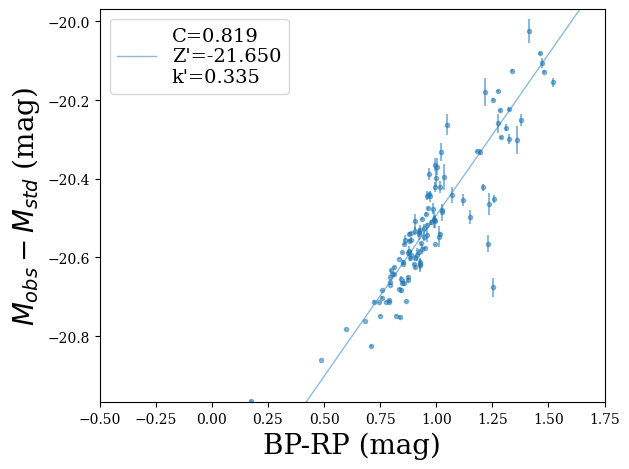

In [138]:

# 오차 막대 그래프 그리기
plt.close()
plt.errorbar(std_star_table['g-r'][indx_filter], delta_mag[indx_filter], yerr=magerr_obs_arr[indx_filter], c=default_colors[ff], alpha=0.5, ls='none', marker='.')

# 회귀선 그리기
plt.plot(x_color, regression_line, color=default_colors[ff], label=f"C={color_term:.3f}\nZ'={Z:.3f}\nk'={k_prime:.3f}", lw=1, zorder=0, alpha=0.5)
# plt.plot(x_color, regression_line_2nd, color=default_colors[nn], label=f"C={color_term_2nd:.3f}\nZ''={Z_2nd:.3f}\nk'={k_prime_2nd:.3f}\nk''={k_2prime_2nd:.3f}", lw=1, ls='--', zorder=0, alpha=0.5)

# 그래프 레이블 및 제한 설정
# plt.xlabel('(g-r) (mag)')
plt.xlabel('BP-RP (mag)')
plt.ylabel(r'$M_{obs}-M_{std}$ (mag)')
plt.xlim(-0.5, +1.75)
plt.ylim([np.median(delta_mag)-0.5, np.median(delta_mag)+0.5])

# 범례 추가
plt.legend(fontsize=14)

# 그래프 보여주기
plt.tight_layout()
plt.show()


In [139]:
label = f"C={color_term:.3f}+/-{color_term_err:.3f}\nZ'={Z:.3f}+/-{Z_err:.3f}\nk'={k_prime:.3f}+/-{k_prime_err:.3f}"

/var/folders/73/438czwkx0jb_7z61gc79vcb40000gn/T/ipykernel_74116/3901963131.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


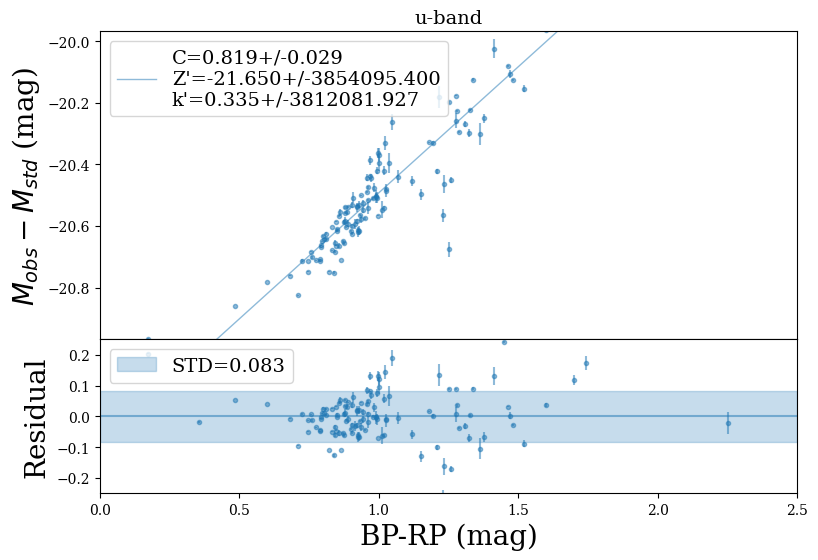

In [140]:
mosaic2 = """
A
A
B
"""

fig, ax = plt.subplot_mosaic(mosaic2, figsize = (9, 6),
                               empty_sentinel = "x",
                               gridspec_kw = dict(wspace = 0.25, hspace = 0.0)
                               )

# 'A' 위치에 오차 막대 그래프와 회귀선 그리기
ax['A'].errorbar(std_star_table['g-r'][indx_filter], delta_mag[indx_filter], yerr=magerr_obs_arr[indx_filter], c=default_colors[ff], alpha=0.5, ls='none', marker='.')
ax['A'].plot(x_color, regression_line, color=default_colors[ff], lw=1, zorder=0, alpha=0.5, label=label,)
# ax['A'].set_xlabel('(g-r) (mag)')
ax['A'].set_xticks([])
ax['A'].set_ylabel(r'$M_{obs}-M_{std}$ (mag)')
ax['A'].set_xlim(0, 2.5)
ax['A'].set_ylim([np.median(delta_mag)-0.5, np.median(delta_mag)+0.5])
ax['A'].legend(loc='upper left', fontsize=14)
ax['A'].set_title(f"{filte}-band")
# 'B' 위치에 잔차 그래프 그리기
residual = delta_mag[indx_filter] - func_color_term(std_star_table['g-r'][indx_filter], color_term, Z, k_prime)
std = np.std(residual)
ax['B'].errorbar(std_star_table['g-r'][indx_filter], residual, yerr=magerr_obs_arr[indx_filter], c=default_colors[ff], alpha=0.5, ls='none', marker='.')
ax['B'].axhline(y=0, color=default_colors[ff], linestyle='-', alpha=0.5)  # y=0 잔차선
ax['B'].axhspan(ymin=-std, ymax=+std, color=default_colors[ff], alpha=0.25, zorder=0, label=f"STD={std:.3f}")
ax['B'].set_xlabel('BP-RP (mag)')
ax['B'].set_ylabel('Residual')
# ax['B'].set_xlim(-0.5, +1.75)
ax['B'].set_xlim(0, 2.5)
ax['B'].set_ylim(-0.25, 0.25)
ax['B'].legend(loc='upper left', fontsize=14)

fig.tight_layout()
plt.show()

fig.savefig(f"{path_save}/{filte}_1st_color_term.png",)